# We vary the capacity of the Bayesian model by changing `hidden_size` parameter, trying to predict the brownian trajectories with a **lot of noise**.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
from brownian_datagen import BrownianDatagen, create_dataholder_for_windows_and_targets
from bayesian import BayesTrainData
from bayesian_varinf import train_fb_n_times, load_learning_curves

In [3]:
def get_save_dir_prefix(hidden_size: int) -> str:
    save_dir_prefix = "20230724_preds/brownian_varinf_hidden_size_noisy/"
    return os.path.join(save_dir_prefix, f"hidden_size={hidden_size:02}/")

hidden_sizes_mesh = (2, 4, 6, 8, 11, 16)

(<Figure size 500x1000 with 3 Axes>,
 array([<Axes: title={'center': 'Forward trajectories'}, xlabel='index', ylabel='coordinate of the particle, forward'>,
        <Axes: title={'center': 'Backward trajectories'}, xlabel='index', ylabel='coordinate of the particle, backward'>,
        <Axes: title={'center': 'Work distributions'}>], dtype=object))

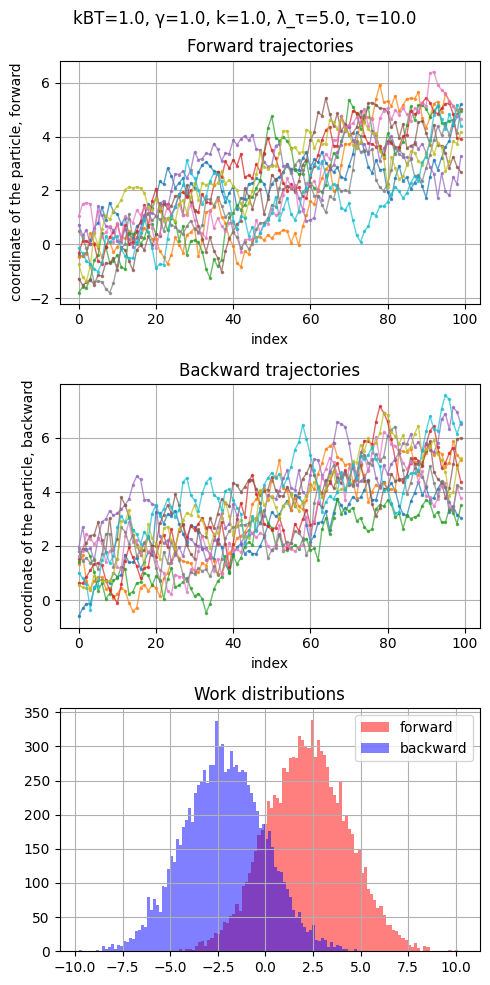

In [4]:
brownian = BrownianDatagen(kBT=1., γ=1., k=1., λ_τ=5., τ=10.)
dt = create_dataholder_for_windows_and_targets(brownian, numParticles=50, rng_seed=42)
brownian.visualize()

In [5]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}")
    assert torch.cuda.is_available()
else:
    print("No GPUs available. Using CPU.")
    assert not torch.cuda.is_available()

No GPUs available. Using CPU.


In [6]:
for hidden_size in hidden_sizes_mesh:
    save_dir_prefix = get_save_dir_prefix(hidden_size)
    if not os.path.isdir(save_dir_prefix):
        train_fb_n_times(dt,
            num_runs=100,
            hidden_size=hidden_size,
            num_epochs=4000,
            save_metrics_every_n_epochs=100,
            train_test_split_ratio=None,
            save_dir_prefix=save_dir_prefix,
            torch_device="cuda:1" if torch.cuda.is_available() else None)
    else:
        print(f"Directory '{save_dir_prefix}' exists, assuming the previous results are reusable")

Directory '20230724_preds/brownian_varinf_hidden_size_noisy/hidden_size=02/' exists, assuming the previous results are reusable
Directory '20230724_preds/brownian_varinf_hidden_size_noisy/hidden_size=04/' exists, assuming the previous results are reusable
Directory '20230724_preds/brownian_varinf_hidden_size_noisy/hidden_size=06/' exists, assuming the previous results are reusable
Directory '20230724_preds/brownian_varinf_hidden_size_noisy/hidden_size=08/' exists, assuming the previous results are reusable
Directory '20230724_preds/brownian_varinf_hidden_size_noisy/hidden_size=11/' exists, assuming the previous results are reusable
Directory '20230724_preds/brownian_varinf_hidden_size_noisy/hidden_size=16/' exists, assuming the previous results are reusable


hidden_size=2


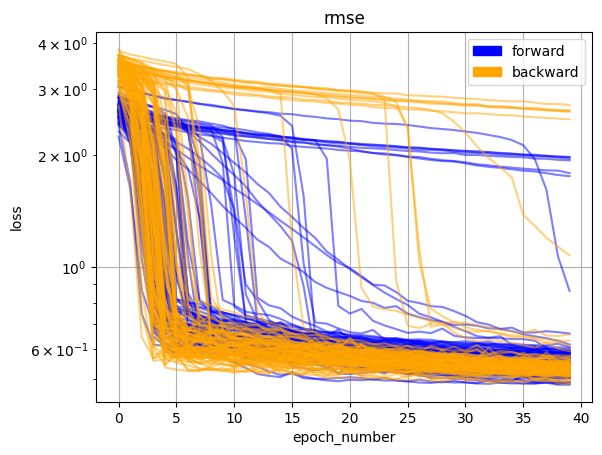

hidden_size=4


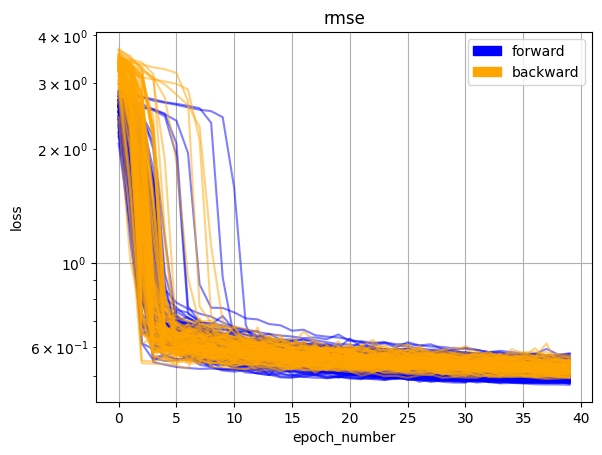

hidden_size=6


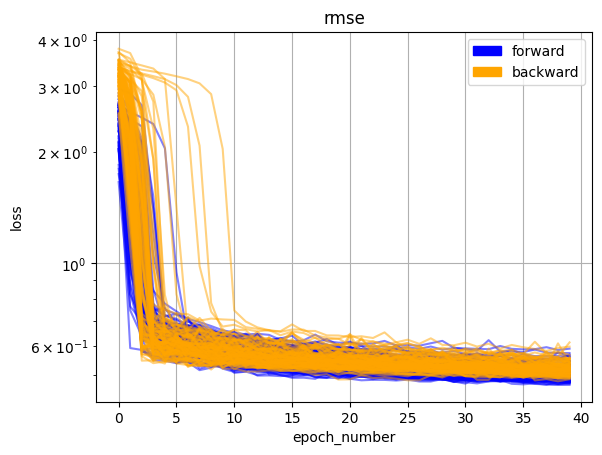

hidden_size=8


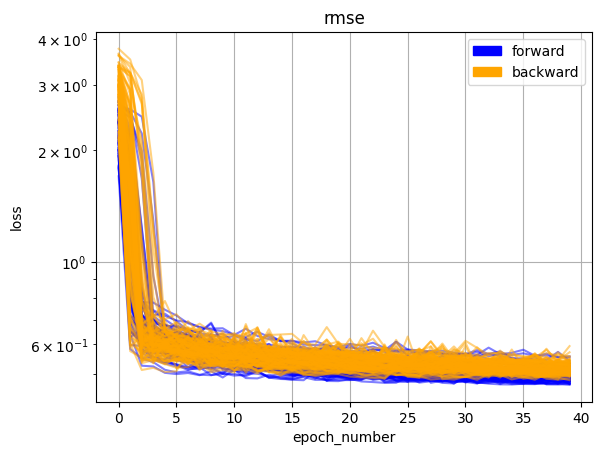

hidden_size=11


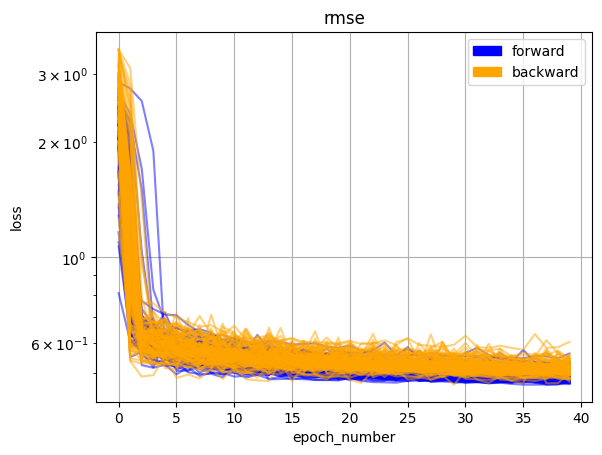

hidden_size=16


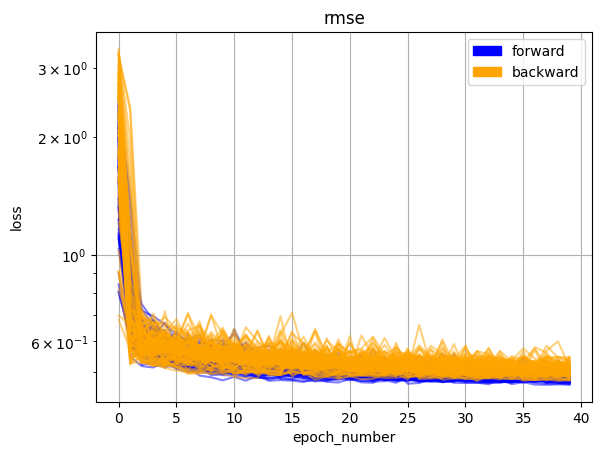

In [7]:
for hidden_size in hidden_sizes_mesh:
    print(f"hidden_size={hidden_size}")
    save_dir_prefix = get_save_dir_prefix(hidden_size)
    l = load_learning_curves(save_dir_prefix, num_runs=100, alt_metric="rmse")
    l.plot_learning_curves()

hidden_size=2


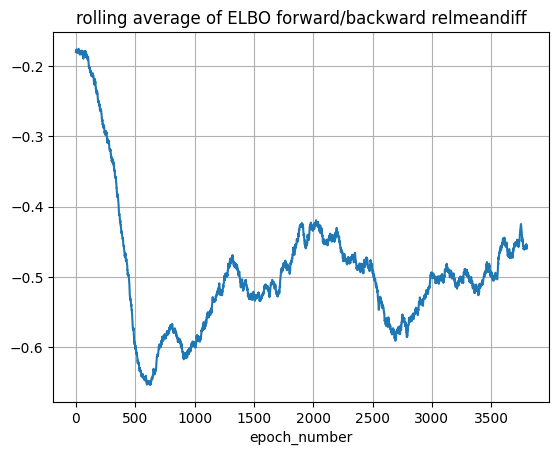

hidden_size=4


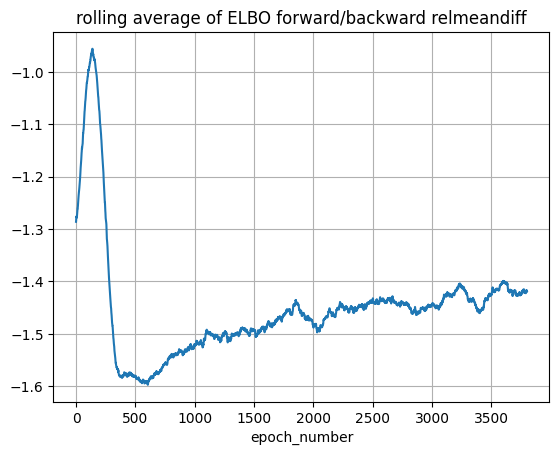

hidden_size=6


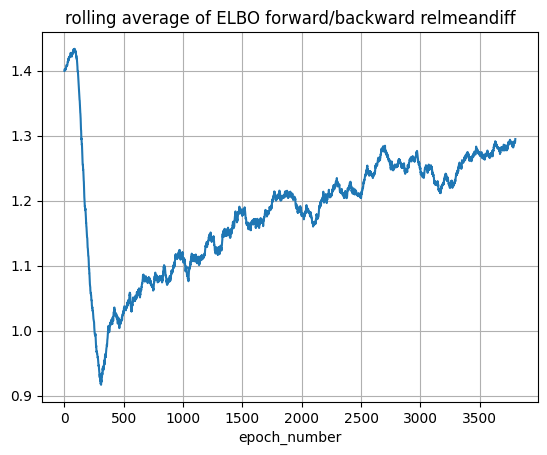

hidden_size=8


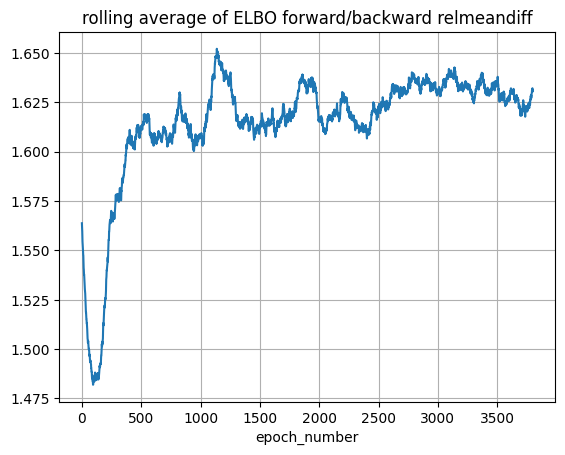

hidden_size=11


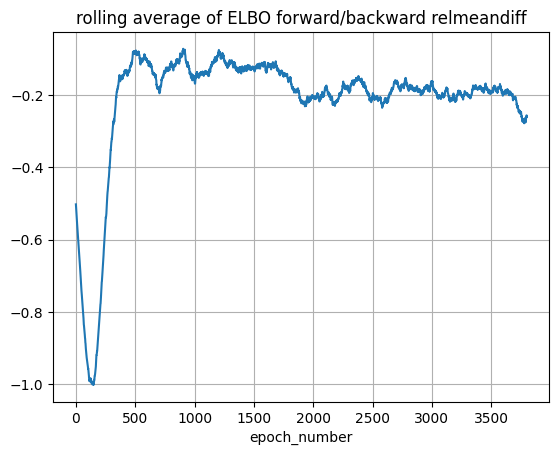

hidden_size=16


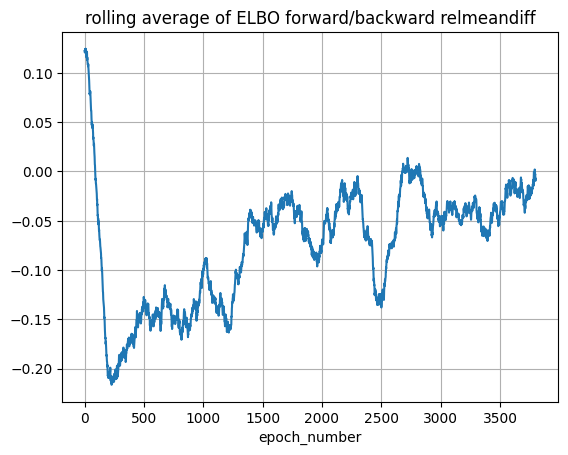

In [8]:
for hidden_size in hidden_sizes_mesh:
    l = load_learning_curves(get_save_dir_prefix(hidden_size), num_runs=100, alt_metric=None)
    print(f"hidden_size={hidden_size}")
    plt.plot(np.convolve(l.relmeandiff_all(), np.ones(200)/200, mode="valid"))
    plt.title("rolling average of ELBO forward/backward relmeandiff")
    plt.grid()
    plt.xlabel("epoch_number")
    plt.show()

hidden_size=2


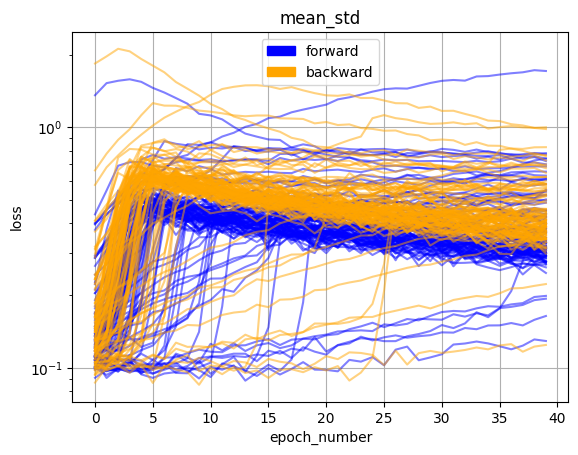

hidden_size=4


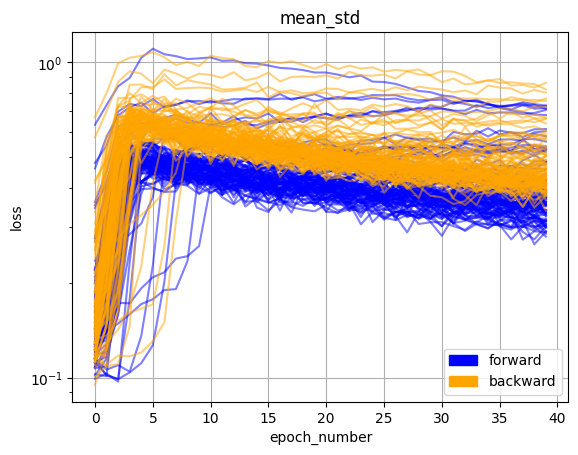

hidden_size=6


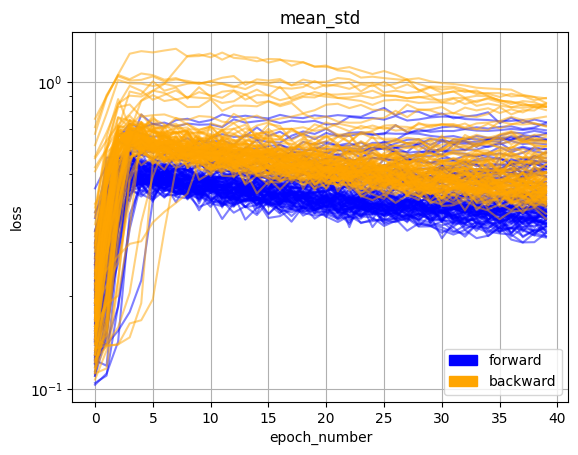

hidden_size=8


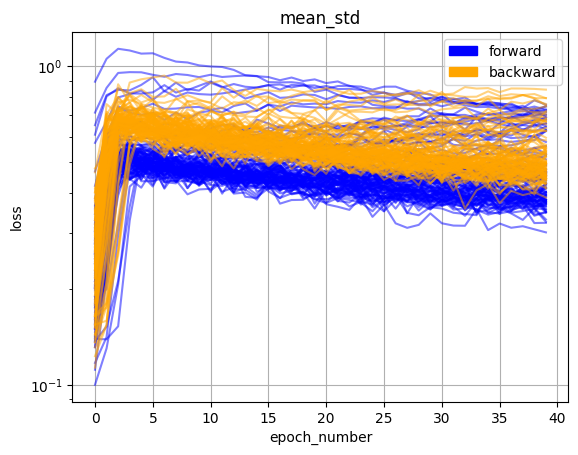

hidden_size=11


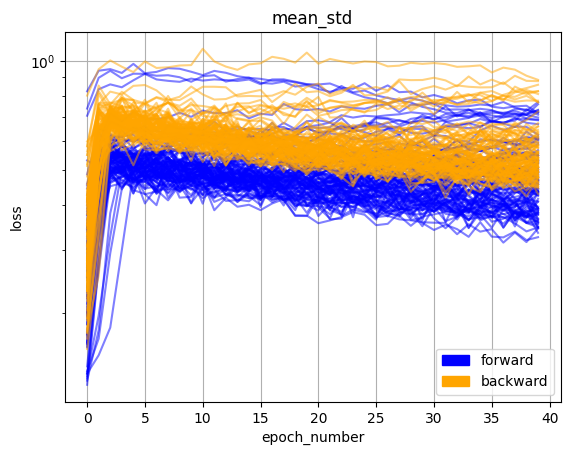

hidden_size=16


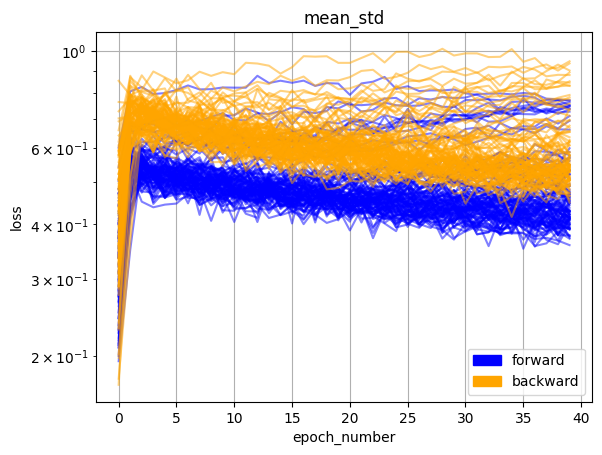

In [9]:
for hidden_size in hidden_sizes_mesh:
    print(f"hidden_size={hidden_size}")
    save_dir_prefix = get_save_dir_prefix(hidden_size)
    l = load_learning_curves(save_dir_prefix, num_runs=100, alt_metric="mean_std")
    l.plot_learning_curves()

## Conclusions

- for small `hidden_size` (2 and 4), there are some outlier learning curves, some runs don't learn at all
- if we ignore outliers, all `hidden_size` lead to roughly same final loss, bigger model do not seem to have an advantage
- forward-backward asymetry is NOT detected by point-estimate losses (`rmse`, `crps`)
- forward-backward asymetry is only seen through `mean_std` (measure of confidence in prediction), forward wins
- with ELBO loss, no trend